# Extract features from textual data using BERT and Path signature

In [1]:
# solve issue with autocomplete
%config Completer.use_jedi = False

%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import pandas as pd
import torch
import pickle
import re

# import sys
# sys.path.insert(0, "../../timeline_generation/")  # Adds higher directory to python modules path
# import src.data_handler

/datadrive/anaconda3/envs/py38esig/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Load dataset

In [3]:
# loadHF: load a dataset from hugging face
from src import loadHF
data_loader = loadHF(dataset_name="newspop", 
                     split_name="train")

In [4]:
# Note: default_preproces_newspop is implemented in loadHF
data_loader.load_preprocessed_df(default_preprocess="newspop")

[INFO] load dataframe, split: train...


/datadrive/anaconda3/envs/py38esig/lib/python3.8/site-packages/huggingface_hub/utils/_deprecation.py:97: FutureWarning: Deprecated argument(s) used in 'dataset_info': token. Will not be supported from version '0.12'.
  warnings.warn(message, FutureWarning)
Using custom data configuration default
Found cached dataset newspop (/home/lwm/.cache/huggingface/datasets/newspop/default/0.0.0/9904d4082ffd3c0953efa538ff926c43d27da8f37c9b5d6a13f51ab96740474e)
100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 566.34it/s]


[INFO] preprocess...
[INFO] preprocessed dataframe can be accessed: .dataset_df


In [5]:
dataset_df = data_loader.dataset_df

In [6]:
dataset_df.head()

,content,datetime,label,timeline_id,postid
0,Obama Lays Wreath at Arlington National Cemete...,2015-01-03 00:12:00,1,5,9
1,"Tim Haywood, investment director business-unit...",2015-01-02 00:00:00,2,2,4
2,"Nouriel Roubini, NYU professor and chairman at...",2015-01-01 00:00:00,2,0,3
3,Finland's economy expanded marginally in the t...,2015-01-04 00:00:00,2,6,9
4,Tourism and public spending continued to boost...,2015-01-06 00:12:00,2,11,9


## Encode labels

In [7]:
# TEST: use a slice of dataset_df

dataset_df = dataset_df[:2000]
dataset_df["label"].value_counts()

0    1131
2     845
1      24
Name: label, dtype: int64

## Model specifics

Nested dictionary for models specifications.

This includes models for encoding text, path signature and etc.

In [27]:
model_specifics = {
    "encoder_args": {
        "col_name_text": "content",
        "model_name": "all-MiniLM-L6-v2",
        "model_args": {
            "batch_size": 64,
            "show_progress_bar": True,
            "output_value": 'sentence_embedding', 
            "convert_to_numpy": True,
            "convert_to_tensor": False,
            "device": None,
            "normalize_embeddings": False
        }
    },
    "dim_reduction": {
        "method": 'umap', #options: ppapca, ppapcappa, umap
        "num_components": 10, # options: any int number between 1 and embedding dimensions
    },
    "time_injection": {
        "history_tp": 'timestamp', #options: timestamp, None
        "post_tp": 'timestamp', #options: timestamp, timediff, None
    },
    "embedding":{
        "global_embedding_tp": 'SBERT', #options: SBERT, BERT_cls , BERT_mean, BERT_max
        "post_embedding_tp": 'sentence', #options: sentence, reduced
        "feature_combination_method": 'attention', #options concatenation, attention 
    },
    "signature": {
        "dimensions": 3, #options: any int number larger than 1
        "method": 'log', # options: log, sig
        "interval": 1/12
    },
    "classifier": {
        "classifier_name": 'FFN2hidden', # options: FFN2hidden (any future classifiers added)
        "classes_num": '3class', #options: 3class (5class to be added in the future)
    }
}

## Encode text and reduce dimensionality

In [28]:
from src import textEncoder
text_encoder = textEncoder(dataset_df,
                           col_name_text=model_specifics["encoder_args"]["col_name_text"], 
                           model_name=model_specifics["encoder_args"]["model_name"],
                           model_args=model_specifics["encoder_args"]["model_args"]
                          )

In [29]:
text_encoder.encode_sentence_transformer()

[INFO] number of sentences to encode: 2000


Batches: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 32/32 [00:10<00:00,  3.03it/s]


In [30]:
embeddings_sentence = text_encoder.embeddings_sentence

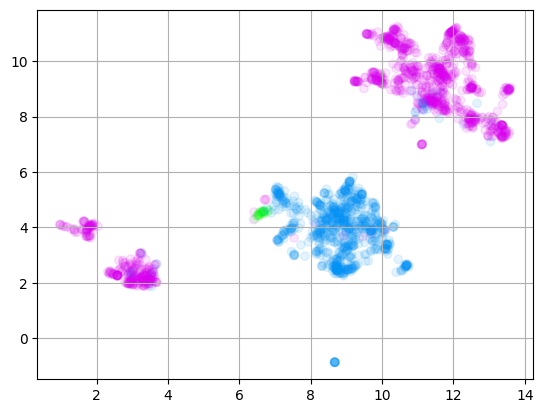

In [31]:
from src import plotEmbedding

plt_embed = plotEmbedding(x_data=embeddings_sentence,
                          y_data=dataset_df["label"].values)

plt_embed.plt_2d(
    embed_args={"method": "umap",
                "dim": 3
               },
    line_args={"alpha": 0.1,
               "marker": "o"
              }
)

## Dimensionality reduction

In [32]:
#dimensionality reduction
from src import DimensionalityReduction

reduction = DimensionalityReduction(method= model_specifics["dim_reduction"]['method'], 
                                    components=model_specifics["dim_reduction"]['num_components'])

In [33]:
embeddings_reduced = reduction.fit_transform(embeddings_sentence)

In [34]:
print(embeddings_sentence.shape)
print(embeddings_reduced.shape)

(2000, 384)
(2000, 10)


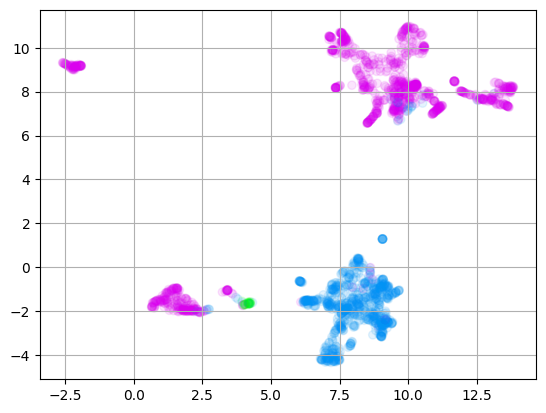

In [35]:
from src import plotEmbedding

plt_embed = plotEmbedding(x_data=embeddings_reduced,
                          y_data=dataset_df["label"].values)

plt_embed.plt_2d(
    embed_args={"method": "umap",
                "dim": 3
               },
    line_args={"alpha": 0.1,
               "marker": "o"
              }
)

## Time injection

In [17]:
#concatenate new dataframe
from src.dataset import get_modeling_dataframe
df = get_modeling_dataframe(dataset_df, embeddings_sentence, embeddings_reduced)

#get time features
from src.timeinjection import TimeFeatures, Padding
tf = TimeFeatures()
df = tf.get_time_features(df)


#padding
pad = Padding()
df_padded = pad.pad_timelines(df)
df_padded.shape

(12, 181, 13)

In [18]:
if (model_specifics["time_injection"]["history_tp"] == 'timestamp'):
    path = torch.from_numpy(df_padded[: , : , 2:].astype(float))
else:
    path = torch.from_numpy(df_padded[: , : , 3:].astype(float))

if (model_specifics["time_injection"]["post_tp"]== 'timestamp'):
    time_feature = torch.tensor((df[['time_encoding']].values - df['time_encoding'].mean()) / df['time_encoding'].std() )
    post_time = True
elif (model_specifics["time_injection"]["post_tp"]== 'timediff'):
    time_feature = torch.tensor( (df[['time_diff']].values - df['time_diff'].mean()) / df['time_diff'].std()  )
    post_time = True  
else: 
    time_feature = None
    post_time = False

if (model_specifics["embedding"]['post_embedding_tp'] == 'sentence'):
    bert_embeddings = torch.tensor(df[[c for c in df.columns if re.match("^e\w*[0-9]", c)]].values)
else:
    bert_embeddings = None

In [19]:
#path = path.squeeze()

## Compute signature and create features

In [20]:
#calculate paths
from src.dyadic_path import DyadicSignatures

dsig = DyadicSignatures(original_size = df.shape[0], 
                        d = path.shape[2], 
                        sig_d = model_specifics["signature"]['dimensions'],
                        intervals = model_specifics["signature"]["interval"], 
                        k_history= None, 
                        embedding_tp = model_specifics["embedding"]['post_embedding_tp'],
                        method = model_specifics["embedding"]['feature_combination_method'],
                        history_tp = model_specifics["signature"]['method'], 
                        add_time = post_time)

In [21]:
sig, last_index_dt_all = dsig.compute_signatures(path)
sig_combined = dsig.combine_signatures(sig)

In [22]:
x_data = dsig.create_features(path, sig_combined, last_index_dt_all, bert_embeddings, time_feature)

In [23]:
sig.shape, last_index_dt_all.shape, sig_combined.shape, x_data.shape

(torch.Size([12, 108, 1463]),
 torch.Size([12, 108]),
 torch.Size([12, 108, 1463]),
 torch.Size([2000, 507]))

## Plot embeddings

In [24]:
from src import plotEmbedding

plt_embed = plotEmbedding(x_data=x_data,
                          y_data=df["label"].values)

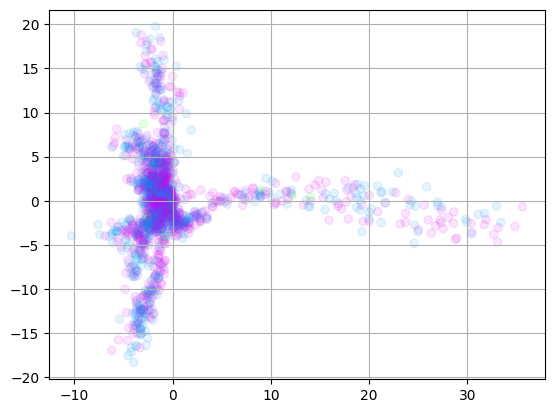

In [25]:
plt_embed.plt_2d(
    embed_args={"method": "pca",
                "dim": 3
               },
    line_args={"alpha": 0.1,
               "marker": "o"
              }
)

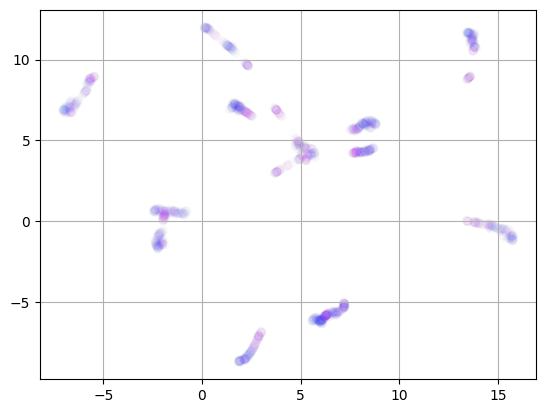

In [26]:
plt_embed.plt_2d(
    embed_args={"method": "umap",
                "dim": 3
               },
    line_args={"alpha": 0.01,
               "marker": "o"
              }
)

## Missing: Training classifiers, cross validation, ...